In [314]:
import json
import regex as re
import random
import datetime
import requests
import time
import pandas as pd
import pymongo
from collections import Counter
import matplotlib.pyplot as plt 
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
def get_player_ids_by_country(country):
    '''use the country's 2-character ISO 3166 code (capitalized) to specify which country you want data 
       for example: United States = US'''
    
    url = f'https://api.chess.com/pub/country/{country}/players'
    response = requests.get(url)
    
    #check if the request worked
    assert response.status_code == 200 
    
    #convert from bytes to utf-8, then to json then pull the names from the dict
    return json.loads(response.content.decode('utf-8'))['players']

def date_joined(username, datetype='epoch'):
    '''returns the date the user joined in epoch time by default, human readable date is returned if datetype=readable'''
    
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        profile = json.loads(response.content.decode('utf-8'))
        if datetype == 'epoch':
            return profile['joined']
        elif datetype == 'readable':
            return datetime.datetime.fromtimestamp(profile['joined']).strftime('%c')
    except:
        return -1

def list_of_players(country, start, end, num_of_players):
    '''use the country's 2-character ISO 3166 code (capitalized) to specify which country you want data from
    Params:
         country: which country players will be selected from ex: US
         start: select players who signed up after this date in epoch time ex: 1514764800 (jan 1st, 2018)
         end: select players who signed up before this date in epoch time ex: 1517443200 (feb 1st, 2018)
         num_of_players: amount of players to analyze 
    '''
    
    #random pick from list of usernames
    player_list = random.sample(get_player_ids_by_country(country), 100000)

#     players = []

    for player in player_list:
        player_count = 0
        joined = date_joined(player)
        if player_count == num_of_players:
            break
        elif (joined > start) and joined < end:
            player_count += 1
#             players.append(player)
            yield player
#     return players

def get_player_profile(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        return json.loads(response.content.decode('utf-8'))
    except:
        return [] 
        
def get_player_stats(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/stats')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []

def get_monthly_archives(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []
        
def get_player_games(username, year='2018'):
    '''return a list of lists where each list contains the games played each month'''
    
    months_with_games_played = get_monthly_archives(username)
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    games = []
    for month in months:
        try:
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month}')
            month_games.append([json.loads(response.content.decode('utf-8'))])
        except:
            continue
    return games

def player_data_to_mongoDB(username, mongoDB_connection, database, collection):
    
    mc = mongoDB_connection
    
    #use/create a database
    db = mc[database]
    
    #use/create a collection
    collection = db[collection]
    
    #query Chess.com api for data
    profile = get_player_profile(username)
    games = get_player_games(username)
    
    #insert player data into database
    collection.insert_one({**profile,
                           'games': games
                            })

def all_player_data_to_mongoDB(players, mongoDB_connection, database, collection, verbose=False):
    '''insert all player data into a mongoDB
       Params:
          players: list of player names
          mongoDB_connection: open connection to database ex. pymongo.MongoClient()
          database: name of database
          collection: name of collection
       Keyword Args:
          verbose: if True print player name after each insert, default is False
    '''
    print(f'importing to {database} database and {collection} collection')
    for player in players:
        player_data_to_mongoDB(player, mongoDB_connection, database, collection)
        if verbose:
            print(player)
    print('All player data inserted into database')
            
def mongoDB_to_pandas(database, collection):
    return pd.DataFrame(list(database[collection].find()))
            
def player_data_to_pandas(database, collection, country, start, end, num_of_players):
    '''return a pandas dataframe with all player data'''
    all_player_data_to_mongoDB(list_of_players(country, start, end, num_of_players), pymongo.MongoClient(), database, collection)
    return mongoDB_to_pandas(database, collection)







def games_in_a_month(games_column, player, month):
    return len(games_column[player][month][0]['games'])
    
def rated_games(games_column, player, month, game):
    return str(games_column[player][month][0]['games'][game]['rated'])

def time_class_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['time_class']

def rules_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['rules']

def eco_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['eco'][31:].split('-')[0]

def results_games(games_column, player, month, game):
    if games_column[player][month][0]['games'][game]['white'] == df.username[0]:
        return games_column[player][month][0]['games'][game]['white']['result']
    else:
        return games_column[player][month][0]['games'][game]['black']['result']

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to locate each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, column='games', verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        column: column containing games, default column name is 'games'
        verbose: if True, print player indices as they are parsed, default is False
    '''
    print('parsing...')
    games_column = df[column]
    player_idx = range(df.shape[0])
    for player in player_idx:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        if len(games_column[player]) != 5:
            continue
        else:
            for month in range(4):
                try:
                    for game in range(games_in_a_month(games_column, player, month)):
                        try:
                            rated.append(rated_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            time_class.append(time_class_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(games_column, player, month, game))
                        except KeyError:
                            continue
#                         try:
#                             eco.append(eco_games(games_column, player, month, game))
#                         except KeyError:
#                             continue
                        try:
                            results.append(results_games(games_column, player, month, game))
                        except KeyError:
                            continue
                except KeyError:
                    continue
                    
            df.loc[player, 'may_games'] = games_in_a_month(games_column, player, 4)
            
            make_columns(time_class, df, player)
            make_columns(rated, df, player)
            make_columns(rules, df, player)
            make_columns(eco, df, player)
            make_columns(results, df, player)
            
def init_columns(df):
    '''Add columns for all rated games, time_class, rules
    Params:
        df: pandas dataframe
    '''
    labels = ['win', 'checkmated', 'agreed', 'repetition', 'timeout', 'resigned', 
              'stalemate', 'lose', 'insufficient', '50move', 'abandoned', 'kingofthehill',
              'threecheck', 'timevsinsufficient', 'bughousepartnerlose', 'False', 'True',
              'standard', 'daily', 'blitz', 'lightning', 'chess960', 'crazyhouse', 'bughouse', 'chess']
    for label in labels:
        df[label] = 0
        
def make_X_and_y(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        X: all important feature columns
        y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)
    '''
    print('making features and target')
    #initialize columns
    init_columns(df)

    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in two weeks (may 1st)
    def is_inactive(x):
        '''checks if value is less than 2
        '''
        if x < 2:
            return 1
        else:
            return 0

    df['inactive'] = df['may_games'].apply(lambda x: is_inactive(x))

    #create columns has_name, has_location, has_avatar
    def has_attribute(x):
        if x != x:
            return 0
        else:
            return 1

    df['has_name'] = df['name'].apply(lambda x: has_attribute(x))
    df['has_location'] = df['location'].apply(lambda x: has_attribute(x))
    df['has_avatar'] = df['avatar'].apply(lambda x: has_attribute(x))

    #make a basic account type column
    def is_basic(x):
        '''check if value is the string basic'''
        if x == 'basic':
            return 1
        else:
            return 0

    df['is_basic'] = df['status'].apply(lambda x: is_basic(x))

    #make a premium account type column
    def is_premium(x):
        '''check if value is the string premium'''
        if x == 'premium':
            return 1
        else:
            return 0

    df['is_premium'] = df['status'].apply(lambda x: is_premium(x))
    
    #assign X and y variables
    y = df['inactive']
    
    X = df.drop(columns=['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz',
                         'chess_bullet', 'chess_daily', 'chess_rapid', 'country',
                         'games', 'last_online', 'location', 'name', 'player_id',
                         'status', 'url', 'username', 'may_games', 'inactive'])
    
    return (X, y)

def api_to_random_forest(database, collection, country, start, end, num_of_players):
    '''returns the AUC score and a fit random forest model
    Params:
         country: which country players will be selected from ex: US
         start: select players who signed up after this date in epoch time ex: 1514764800 (jan 1st, 2018)
         end: select players who signed up before this date in epoch time ex: 1517443200 (feb 1st, 2018)
         num_of_players: amount of players to analyze 
    '''
    player_data_to_pandas(database, collection, country, start, end, num_of_players)

    #remove duplicate users by player_id
    df.drop_duplicates(subset='player_id', inplace=True)

    #reset the index
    df.reset_index(drop=True, inplace=True)

    #create features and target
    X, y = make_X_and_y(df)

    print('train, test, spliting')
    #make a train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    print('making predictions....')
    #make predictions using random forest
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    y_predict = random_forest.predict_proba(X_test)
    
    return (roc_auc_score(y_test, y_predict[:, 1]), random_forest)

In [ ]:
my_whole_project('chess_predictions', 'players_testrun2', 'US', 1514764800, 1517443200, 10)

importing to chess_predictions database and players_testrun2 collection


In [58]:
all_player_data_to_mongoDB(full_player_names, pymongo.MongoClient(), 'chess_predictions', 'players', verbose=True)

0ldtower
0rlandomagic
0xvyper
101arrowz
108daniel
10thplanetchess
1103chucky
1122mata
11brian11
12122323
123babelfish
123paulb
1336067
141269
153fishfromthesea
1985has
1995diakonia
19ccollins
19raidernation74
1ferdman
1foutsda1
1kingservant
1ln
1nghia
1srose80
1timbob
2000horses
2015sti
201701573
209rayzor
21jtworks
21kaladi
22cabbage
23shaman
29tonygong
2bfenn
2elvemsrs
2old2slow
2pawn1
2weeeeee
300wssm
32010204
321collins
3c0x1
3happiness
40dog
48823
49erdude
4movegroove
4play1132
4rkum8
50york
510tone
60piece
66iglesias
6jfisher
70281381
72treadaway
77746920
777lucky69
7miledb
7myboyz7
7teal7
804659
889874
8ibol
8pawnproblem
9011935
9729037
9fa
9kanth
a_e_s_t_h_e_t_e
a_faliure
a-arons
a-club
a3cow05
a67cabrera
aa_ethan_zz
aaachesstrack101
aabdullah014
aag02013
aardjess
aarfo38
aaronak47
aaronbel88
aaroncz
aaroneicoff
aaronjonasen
aaronwingert
aaverbuj
aawp
abarnard1
abbank
abc92zxc
abcde45
abdikafigeedi
abdulameer1
abe-city
abelcastaneda
abelskinner
abhishastry123
abhishekyadav1098


In [57]:
player_data_to_mongoDB('0rlandomagic', pymongo.MongoClient(), 'chess_predictions', 'players')

# Important Endpoints from Chess.com

## Player Profile
### Description: Get additional details about a player in a game. 
URL pattern: https://api.chess.com/pub/player/{username} 

{
  "@id": "URL", // the location of this profile (always self-referencing)
  
  "url": "URL", // the chess.com user's profile page (the username is displayed with the original letter case)
  
  "username": "string", // the username of this player
  
  "player_id": 41, // the non-changing Chess.com ID of this player
  
  "title": "string", // (optional) abbreviation of chess title, if any
  
  "status": "string", // account status: closed, closed:fair_play_violations, basic, premium, mod, staff
  
  "name": "string", // (optional) the personal first and last name
  
  "avatar": "URL", // (optional) URL of a 200x200 image
  
  "location": "string", // (optional) the city or location
  
  "country": "URL", // API location of this player's country's profile
  
  "joined": 1178556600, // timestamp of registration on Chess.com
  
  "last_online": 1500661803, // timestamp of the most recent login
  
  "followers": 17 // the number of players tracking this player's activity
}


## Player Stats
### Description: Get ratings, win/loss, and other stats about a player's game play. 
URL pattern: https://api.chess.com/pub/player/{username}/stats

"chess_daily": {
/* stats object for games of rules "chess" and "daily" time-class */


"chess960_daily": {
/* stats object for games of rules "chess960" and "daily" time-class */


"chess_blitz": {
/* stats object for games of rules "chess" and "blitz" time-class */


### In each dictionary:

{
  "last": { // the current stats
  
    "date": 1509709165, // timestamp of the last rated game finished
    
    "rating": 1642, // most-recent rating
    
    "rd": 58 // the Glicko "RD" value used to calculate ratings changes
    
  },
  "best": { // the best rating achieved by a win
  
    "date": 1256228875, // timestamp of the best-win game
    
    "rating": 2065, // highest rating achieved
    
    "game": "URL" // URL of the best-win game
    
  },
  "record": { // summary of all games played
  
    "win": 177,  // number of games won
    
    "loss": 124, // number of games lost
    
    "draw": 21,  // number of games drawn
    
    "time_per_move": 18799, // integer number of seconds per average move
    
    "timeout_percent": 9.99 // timeout percentage in the last 90 days
    
    
  },
  "tournament": { // summary of tournaments participated in
  
    "count": 20,   // number of tournaments joined
    
    "withdraw": 1, // number of tournaments withdrawn from
    
    "points": 39,  // total number of points earned in tournaments
    
    "highest_finish": 1 // best tournament place
  }
}

## List of Monthly Archives
### Description: Array of monthly archives available for this player. 
URL pattern: https://api.chess.com/pub/player/{username}/games/archives


  "archives":
    /* array of URLs for monthly archives in ascending chronological order */

## Complete Monthly Archives
### Description: Array of Live and Daily Chess games that a player has finished. 
URL pattern: https://api.chess.com/pub/player/{username}/games/{YYYY}/{MM}

"YYYY" is the four digit year of the game-end

"MM" is the two-digit month

Data Format, each Game:

{
  "white": { // details of the white-piece player:
  
    "username": "string", // the username
    
    "rating": 1492, // the player's rating at the start of the game
    
    "result": "string", // see "Game results codes" section
    
    "@id": "string", // URL of this player's profile
    
  },
  "black": { // details of the black-piece player:
  
    "username": "string", // the username
    
    "rating": 1942, // the player's rating at the start of the game
    
    "result": "string", // see "Game results codes" section
    
    "@id": "string", // URL of this player's profile
    
  },
  "url": "string", // URL of this game
  
  "fen": "string", // final FEN
  
  "pgn": "string", // final PGN
  
  "start_time": 1254438881, // timestamp of the game start (Daily Chess only)
  
  "end_time": 1254670734, // timestamp of the game end
  
  "time_control": "string", // PGN-compliant time control
  
  "rules": "string", // game variant information (e.g., "chess960")
  
  "eco": "string", //URL pointing to ECO opening (if available),
  
  "tournament": "string", //URL pointing to tournament (if available),  
  
  "match": "string", //URL pointing to team match (if available)  
  
}

In [346]:
def get_monthly_archives(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        months_played = json.loads(response.content.decode('utf-8'))['archives']
        return [month[-7:].split('/') for month in months_played]
    except:
        return []
        
def get_player_games(username):
    '''return a list of all games played by a user'''
    
    months = get_monthly_archives(username)
    games = []
    if months:
        for month in months:
            year = month[0]
            month_ = month[1]
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month_}')
            for game in json.loads(response.content.decode('utf-8'))['games']:
                games.append(game)
    return games

In [235]:
get_player_games('4swb')

[{'black': {'@id': 'https://api.chess.com/pub/player/catali',
   'rating': 1146,
   'result': 'resigned',
   'username': 'catali'},
  'end_time': 1406239188,
  'fen': '8/8/2p3k1/1p1p4/1P3KP1/P1P5/7P/8 b - g3',
  'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2014.07.24"]\n[Round "-"]\n[White "4swb"]\n[Black "catali"]\n[Result "1-0"]\n[ECO "C00"]\n[ECOUrl "https://www.chess.com/openings/C00-French-Defense-Knight-Variation-2...d5"]\n[WhiteElo "1184"]\n[BlackElo "1166"]\n[TimeControl "600"]\n[Termination "4swb won by resignation"]\n[StartTime "21:59:48"]\n[EndDate "2014.07.24"]\n[EndTime "21:59:48"]\n[Link "https://www.chess.com/live/game/869038626"]\n\n1. e4 {[%clk 0:10:00]} 1... e6 {[%clk 0:10:00]} 2. Nf3 {[%clk 0:09:55.8]} 2... d5 {[%clk 0:09:57.6]} 3. exd5 {[%clk 0:09:45.9]} 3... exd5 {[%clk 0:09:53.8]} 4. d4 {[%clk 0:09:42.7]} 4... Nf6 {[%clk 0:09:52]} 5. Nc3 {[%clk 0:09:33.6]} 5... Bb4 {[%clk 0:09:48.4]} 6. Bd2 {[%clk 0:09:28.8]} 6... c6 {[%clk 0:09:39]} 7. Be2 {[%clk 0:09

In [236]:
g = _

In [267]:
g[150]['pgn']

'[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2014.08.01"]\n[Round "-"]\n[White "Magoo4u"]\n[Black "4swb"]\n[Result "0-1"]\n[ECO "B20"]\n[ECOUrl "https://www.chess.com/openings/B20-Sicilian-Defense"]\n[WhiteElo "1100"]\n[BlackElo "1436"]\n[TimeControl "1800"]\n[Termination "4swb won - game abandoned"]\n[StartTime "03:04:04"]\n[EndDate "2014.08.01"]\n[EndTime "03:04:04"]\n[Link "https://www.chess.com/live/game/875345916"]\n\n1. e4 {[%clk 0:28:58.5]} 1... c5 {[%clk 0:29:14.7]} 0-1'

In [266]:
re.split("(\d+)\.+ ", g[150]['pgn'])[-2]

'1'

In [252]:
re.split("(\d+\.+ )", g[1635]['pgn'].split('\n\n')[-1])

['', '1. ', 'e4 {[%clk 0:10:00]} 1-0']

In [260]:
re.split(" (\d+)\.", g[34]['pgn'])[-2]
    

'16'

In [97]:
num[:2]

'19'

In [761]:
def game_stats_df(username):
    game_list = get_player_games(username)
    player_rating = []
    rating_difference = []
    player_result = []
    player_username = []
    end_time = []
    pgn = []
    eco = []
    rated = []
    time_class = []
    rules = []
    game_length = []
    player_color = []

    for i, game in enumerate(game_list):
        
        starting_position = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'
        
        if (game['rules'] == 'chess') and (game['fen'] != starting_position):
            pgn_data = game['pgn'].split('\n')
            pgn.append(pgn_data[-1])
            eco.append(pgn_data[7].split('"')[-2])
            game_length.append(int(re.split("(\d+)\.+", game['pgn'])[-2]))
#             print(i, re.split("(\d+)\.+", game['pgn'])[-2])
        else:
            pgn.append(None)
            eco.append(None)
            game_length.append(None)
            
        if game['black']['username'].lower() == username.lower():
            player_rating.append(game['black']['rating'])
            rating_difference.append(game['black']['rating'] - game['white']['rating'])
            player_result.append(game['black']['result'])
            player_username.append(game['black']['username'])
            player_color.append('black')
        else:
            player_rating.append(game['white']['rating'])
            rating_difference.append(game['white']['rating'] - game['black']['rating'])
            player_result.append(game['white']['result'])
            player_username.append(game['white']['username'])
            player_color.append('white')
            
        end_time.append(pd.to_datetime(game['end_time'], unit='s'))
        rated.append(game['rated'])
        time_class.append(game['time_class'])
        rules.append(game['rules'])

    df = pd.DataFrame({'player_username': player_username,
                       'player_color': player_color,
                       'player_rating': player_rating,
                       'rating_difference': rating_difference,
                       'player_result': player_result,
                       'end_time': end_time,
                       'rated': rated,
                       'time_class': time_class,
                       'rules': rules,
                       'pgn': pgn,
                       'eco': eco,
                       'game_length':game_length})
    return df

In [762]:
stats_df = game_stats_df('davparker')

In [775]:
stats_df

,eco,end_time,game_length,pgn,player_color,player_rating,player_result,player_username,rated,rating_difference,rules,time_class
1262,None,2017-01-31 17:40:35,NaN,None,black,1222,win,davparker,True,41,chess,blitz


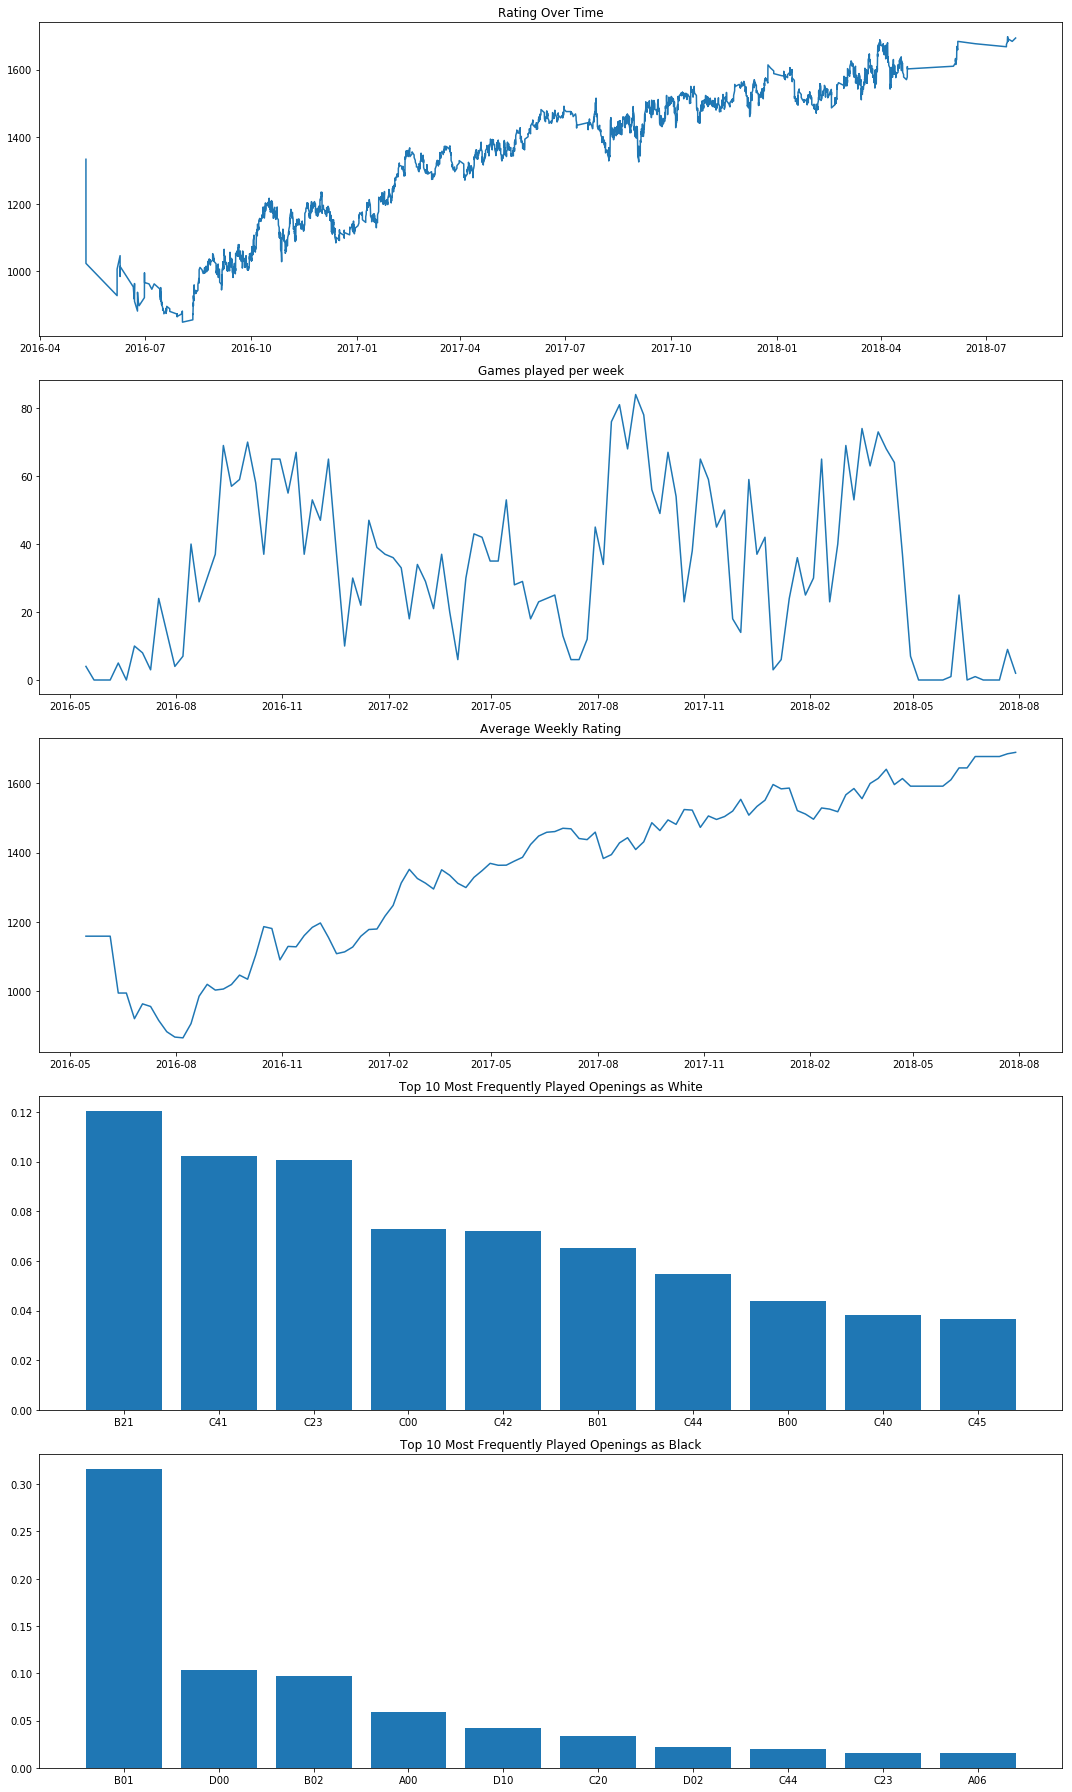

In [763]:
fig, ax = plt.subplots(5, figsize=(15, 25))

blitz_chess_df = stats_df[(stats_df['rules'] == 'chess') & (stats_df['time_class'] == 'blitz')]

ax[0].plot(blitz_chess_df['end_time'], blitz_chess_df['player_rating'])
ax[0].set_title('Rating Over Time')

ax[1].plot(blitz_chess_df.resample('W', on='end_time').size())
ax[1].set_title('Games played per week')

ax[2].plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'))
ax[2].set_title('Average Weekly Rating')

x = np.arange(len(openings_white))
num_of_openings = 10

games_played_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_of_openings].values
openings_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_of_openings].index

ax[3].bar(x, games_played_white)
ax[3].set_title(f'Top {num_of_openings} Most Frequently Played Openings as White')
ax[3].set_xticks(x)
ax[3].set_xticklabels(openings_white);

games_played_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_of_openings].values
openings_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_of_openings].index

ax[4].bar(x, games_played_black)
ax[4].set_title(f'Top {num_of_openings} Most Frequently Played Openings as Black')
ax[4].set_xticks(x)
ax[4].set_xticklabels(openings_black)

fig.tight_layout();

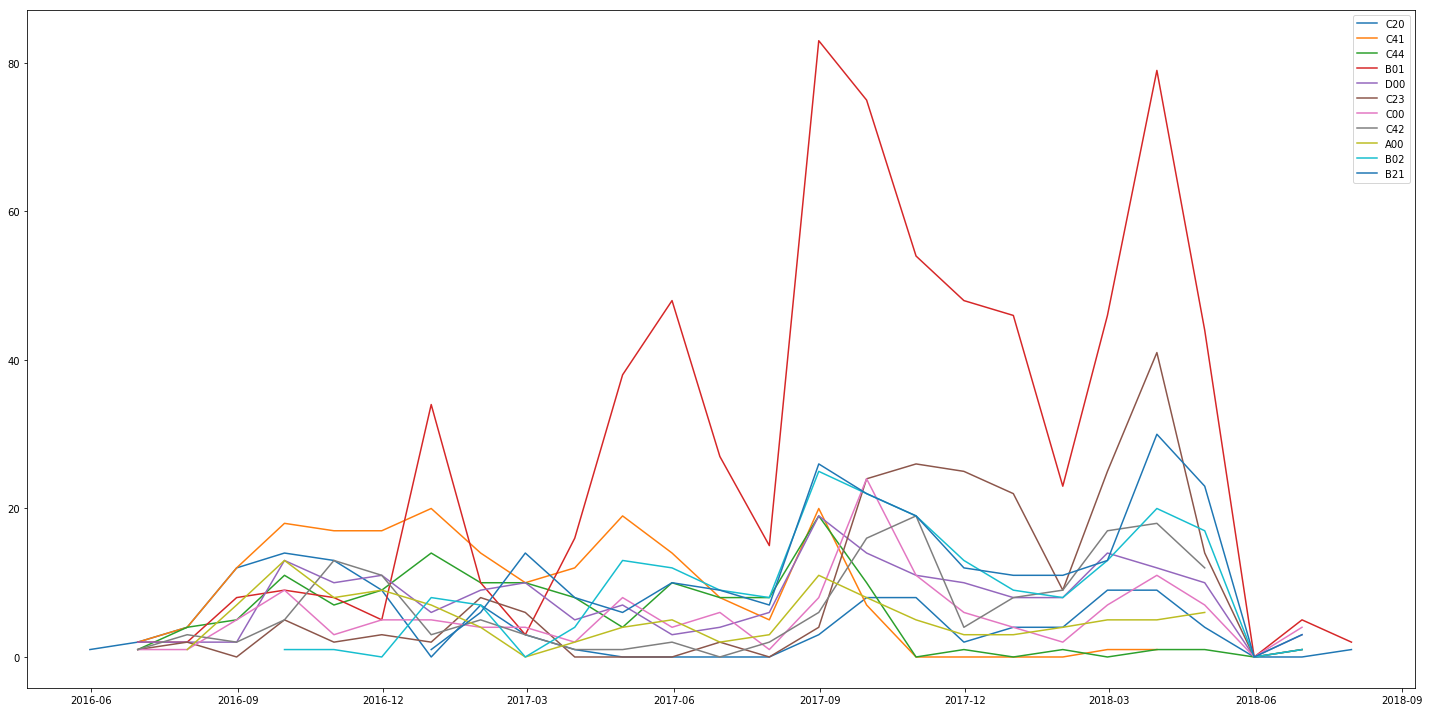

In [770]:
fig, ax = plt.subplots(figsize=(20, 10))

openings = blitz_chess_df['eco'].unique()
total_games = blitz_chess_df.shape[0]
games_per_week = blitz_chess_df.resample('M', on='end_time').size()

for opening in openings:
    games_with_opening = blitz_chess_df[blitz_chess_df['eco'] == opening].resample('M', on='end_time').size().sum()
    percentage_of_games_with_opening = games_with_opening / total_games
    
    if (percentage_of_games_with_opening) > 0.03:
        ax.plot(blitz_chess_df[blitz_chess_df.eco == opening].resample('M', on='end_time').size(), label=opening)
        ax.legend()
fig.tight_layout()

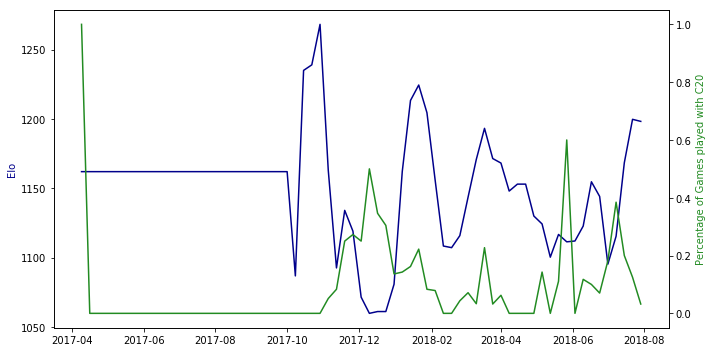

In [757]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()

opening = 'C20'
ax2.plot((blitz_chess_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size() /
          blitz_chess_df.resample('W', on='end_time').size()).fillna(0),
         'forestgreen')
ax2.set_ylabel(f'Percentage of Games played with {opening}', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')

fig.tight_layout()

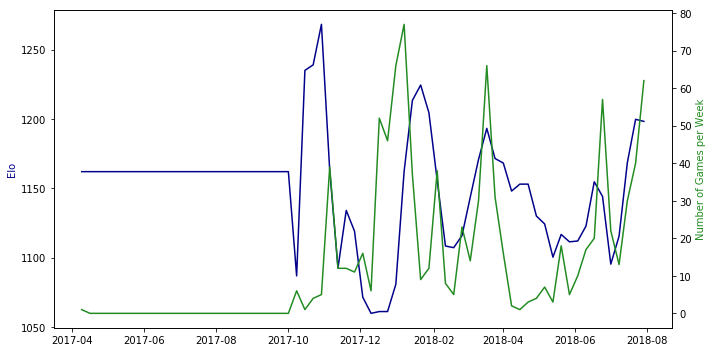

In [758]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()

ax2.plot(blitz_chess_df.resample('W', on='end_time').size(), 'forestgreen')
ax2.set_ylabel('Number of Games per Week', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')
         
fig.tight_layout()